In [3]:
#basic libraries
from math import *
import random
import pandas as pd
import numpy as np
import numpy.matlib

#creation of dictionaries
from collections import defaultdict
from collections import Counter

#file saving and format
import pickle
import ast

#clustering
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
#SVD method
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

#preprocesisng
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Useful functions to save and load files in pickle format
def save_dict(obj, name ):
    with open(f'{name}.pickle', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(f'{name}.pickle', 'rb') as f:
        return pickle.load(f)

## Import Data

In [3]:
data = pd.read_csv('Reviews.csv', usecols = ['ProductId','Summary','Text'])

In [4]:
data.head()

,ProductId,Summary,Text
0,B001E4KFG0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
#an example of a text that we will have to analyze
data.Text[6745]

"I love juice and I love carbonated beverages, but it is difficult to see this product having a long retail life.<br /><br />Essentially, this is a good drink that doesn't really do anything well.<br /><br />It doesn't taste good enough to be a juice replacement--and is there really a need for a juice replacement?  It might have limited value in camping situations or during other times where small cans make better travelers.<br /><br />It's not exactly a post-workout recovery drink.  Juice would be better.  Minute Maid juice, for instance, has less sugar and carbohydrates, even though Switch doesn't add any sugar.  And there are plenty of other juices that have more nutrients, including Calcium and other vitamins and supplements, including potassium.  So, it's less healthy than most juices.<br /><br />Switch isn't exactly a diet soda because of the natural sugar content comapared to zero sugar in diet drinks.<br /><br />As a regular alternative to sugared soda, it tastes good, but ther

# Analysis of the dataset

In [6]:
print(f'number of unique products: {len(data.ProductId.unique())} \nnumber of total rows in the dataset: {data.shape[0]}')

number of unique products: 74258 
number of total rows in the dataset: 568454


In [7]:
data.groupby('ProductId').count()

,Summary,Text
ProductId,,
0006641040,37,37
141278509X,1,1
2734888454,2,2
2841233731,1,1
7310172001,173,173
...,...,...
B009UOFTUI,1,1
B009UOFU20,1,1
B009UUS05I,1,1


In [8]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  568454 non-null  object
 1   Summary    568427 non-null  object
 2   Text       568454 non-null  object
dtypes: object(3)
memory usage: 13.0+ MB


## 1. Preprocessing

The first step in the analysis is the **pre-processing stage**.This  refers to the series of treatments that must be done to the corpus so that it's easier to analyze. The pre-processing part contains the following parts:
- **Corpus tokenization**, that is, divide the different texts into individual words.
- **Stop words removal**, which are common words (a, the, not, etc) that bring close to no contribution to the semantic meaning of a text
- **Noise removal** from the texts. This step will remove anything that can’t be recongnized as a english word, such as words with non ASCII symbols, words together with numbers, etc.
- **Stemming**, which reduces a word to it’s root. 
- **lower case and punctuation removal**

In [10]:
def pre_processing_data(text):           
    
    stop_words = set(stopwords.words('english'))
    text = (text.lower()).replace('\\n',' ')        #converts to lower case and removes extra space
    
    text = text.replace("\r","")
    text = text.replace("\n","")
    text = text.replace("<br />","")
    
    text = text.encode("ascii", "ignore")            #removes non ASCII characters
    text = text.decode()
    
    punctuation = RegexpTokenizer(r'\w+')               #identifies punctuation
    tokens = punctuation.tokenize(text)               #create a list of all words

    ps = PorterStemmer()

    filtered_text = []
    for word in tokens:
        if word not in stop_words:
            filtered_text.append(ps.stem(word))
    
    return filtered_text

#### All the cells below were runned only the FIRST time and then saved into a csv file for easier access

`wordlist = data['Text'].apply(lambda text: fn.pre_processing_data(text))`

`data['text_words'] = wordlist`

In [86]:
data.head(10)

,ProductId,Summary,Text,text_words
0,B001E4KFG0,Good Quality Dog Food,I have bought several of the Vitality canned d...,"[bought, sever, vital, can, dog, food, product..."
1,B00813GRG4,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"[product, arriv, label, jumbo, salt, peanut, p..."
2,B000LQOCH0,"""Delight"" says it all",This is a confection that has been around a fe...,"[confect, around, centuri, light, pillowi, cit..."
3,B000UA0QIQ,Cough Medicine,If you are looking for the secret ingredient i...,"[look, secret, ingredi, robitussin, believ, fo..."
4,B006K2ZZ7K,Great taffy,Great taffy at a great price. There was a wid...,"[great, taffi, great, price, wide, assort, yum..."
5,B006K2ZZ7K,Nice Taffy,I got a wild hair for taffy and ordered this f...,"[got, wild, hair, taffi, order, five, pound, b..."
6,B006K2ZZ7K,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,"[saltwat, taffi, great, flavor, soft, chewi, c..."
7,B006K2ZZ7K,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,"[taffi, good, soft, chewi, flavor, amaz, would..."
8,B000E7L2R4,Yay Barley,Right now I'm mostly just sprouting this so my...,"[right, mostli, sprout, cat, eat, grass, love,..."
9,B00171APVA,Healthy Dog Food,This is a very healthy dog food. Good for thei...,"[healthi, dog, food, good, digest, also, good,..."


`data.to_csv('clean_dataset.csv')`

In [3]:
#to import directly the filtered dataset instead of pre-process everything again
data = pd.read_csv('clean_dataset.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

#to mantain the format of text_words as a list and not as a string
data['text_words'] = data['text_words'].map(ast.literal_eval)

## 2. Create a vocabulary with all the unique words from text_words
In this step we are going to take into account the last column of the dataset that contains the pre-processed words of each review. From this list of words we are going to create a useful dictionary that maps each unique term into an integer

In [13]:
'''this function takes in input a whole dataframe and returns a dictonary 
   where the keys are all the unique words found in the column 'text_words'
   of the dataframe, and for values an identificative number'''

def build_dictionary(df):                            

    vocabulary_list = []
    vocabs_in_reviews = defaultdict(list)

    for i in range(len(df)):

        text_filtered = df['text_words'][i]
        
        vocabs_review_i=set()
        for word in text_filtered:
            vocabs_review_i.add(word)

        vocabulary_list.append(vocabs_review_i)
        vocabs_in_reviews[i]=list(vocabs_review_i)

    bag_of_words = set.union(*vocabulary_list)
    
    dictionary = {}
    for num, word in enumerate(bag_of_words):
        dictionary[word] = num
    
    return dictionary

`dictionary = build_dictionary(data)`   -    to build

`save_dict(dictionary,'dictionary')` - to save

In [4]:
dictionary = load_obj('dictionary')   #to load it back

In [15]:
len(dictionary)

109234

## 3. For every unique product ID combine the list of words from different reviews together 
We noticed in our firts analysis that the number of unique products is much smaller than the number of rows in our dataframe. We so concluded that there were different reviews written by different users that refferred to the same exact product. We decided to group all these reviews together by creating a dictionary that will be saved and then recalled as **reviews_per_product** that has for:
- **keys** the product ID
- **values** a list of pre-processed words from all the different reviews of the same product

We will, as first thing, create two different lists: one that contains all the productsID of each row of the original dataset, and one, more important, that contains only the ID's of the unique products

In [5]:
products = list([data.ProductId[i] for i in range(len(data))])
unique_products = list(dict.fromkeys(products))

In [6]:
print(len(products))
print(len(unique_products))

568454
74258


In [ ]:
def combine_reviews_for_products(unique_products, data)

    new_data = dict.fromkeys(unique_products)

    for product in unique_products:
        index = (np.where(data['ProductId']==product))[0].tolist()

        reviews = []
        for i in index:
            text = data['text_words'][i]
            reviews += text

        new_data[product] = reviews
        
    return new_data

`new_data = fn.combine_reviews_for_products(unique_products, data)` - to build

`save_dict(new_data,'new_data')` - to save

In [7]:
reviews_per_product = load_obj('new_data') #to load

Going on with our initial analysis of the dataset that aims to prepare a final output that will be convenient for theimplementation of the K-Means algorithm, we wanto the calculate the frequence of each word for each productID

In [8]:
frequency_of_word = []
for key, item in reviews_per_product.items():
    frequency_of_words = Counter(item)
    frequency_of_word.append(frequency_of_words)

And then, we will use it to obtain the absolute frequence of each unique word, that we will savein a dictionary called **frequencies**

In [44]:
def frequency(vocabulary,frequency_of_word):
    f = defaultdict()
    for word in vocabulary.keys():
        f[word] = sum(frequency_of_word[i][word] for i in range(len(frequency_of_word)) if word in frequency_of_word[i])
    return f   

`freq = fn.frequency(dictionary,frequency_of_word)`

`save_dict(freq,'frequencies')` - to save

In [9]:
frequencies = load_obj('frequencies') #to load

Now we have all the elements to make some considerations: we noticed that, from the original vocabulary, we have **109234 unique words**. For the implementation of the algorithm, these words are too many. We want to find a way to reduce the number of words to consider by selecting only the ones that will be actually significant in the clusterization of the products

In [13]:
print('max: ',max(list(frequencies.values())))
print('min: ',min(list(frequencies.values())))

max:  288508
min:  1


In order to do so, we first filtered the list of words by removing the one that have a really low frequence (<20) since are words too unusual, technical or maybe they could be wrong words, with spelling mistakes, hence, with no meaning. At the same time we want to remove words. with a very high frequence (>200000) since these words are too common and will not help in dividing the products into similar groups, which is aour final goal.

In [10]:
def filter_words(frequencies):
    
    useful_words = []                                 #list that contains all the words that we think are useful for clustering
    frequent_words = []                               #list that contains all the words over a certain treshold 

    for key, value in frequencies.items():
        if value > 20 and value < 200000:             #we decided to only consider the words that are inside this range of frewuencies 
            useful_words.append(key)
        elif value > 200000:
            frequent_words.append(key)
    
    return(useful_words, frequent_words)

In [ ]:
output = fn.filter_words(frequencies)
useful_words = output[0] 
frequent_words = output[1]

In [12]:
def new_dictionary(useful_words):
    
    dictionary = defaultdict()
    
    for i, word in enumerate(useful_words):
        dictionary[word] = i
    
    return dictionary

dictionary_filtered = new_dictionary(useful_words)

By doing this we will reduce the length of the dictionary that will contain all the different unique words found inside the reviews from `len(dictionary) = 109234 ` to `len(useful_words) = 14783 `

In [11]:
frequent_words

['product', 'good', 'tast', 'flavor', 'like']

As we can see above, all the words with very high frequencies are very common words, so they will not be useful in the determination of the cluster in which a certain review will belong.

## 4. Matrix product/word

Now we want to create a matrix that will have the following structure:
- each column will represent one word from the list **useful_words**
- each row represents a different unique product id

Each **cell** of the matrix will represent the frequence of that certain word inside the reviews of that certain product

In [13]:
matrix = np.zeros((len(unique_products),len(dictionary_filtered)))
for i, product in enumerate(unique_products):           #per ogni prodotto con indice i   
    for word,j in dictionary_filtered.items():          #per ogni parola con indice j nel dizionario
        if word in frequency_of_word[i].keys():         #se la parola si trova nel dizionario di frequenze del prodotto
            matrix[i][j] += frequency_of_word[i][word]

In [14]:
matrix.shape

(74258, 14783)

## 5. Singular Value Decomposition 

Now that we have a first reduction of the significat words, we want to apply the **SVD Method** to further reduce them, while, at the same time, we still have a high level of variance explained by those words

In [16]:
svd = TruncatedSVD(n_components = 70,n_iter=3, random_state=42)
svd.fit(matrix)

TruncatedSVD(n_components=70, n_iter=3, random_state=42)

In [17]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 88%


In [18]:
svd.components_.shape

(70, 14783)

In [19]:
svd.singular_values_

array([14075.00253347,  9413.25706533,  6734.25180712,  5593.33577997,
        5539.76174193,  5249.7451622 ,  4378.87047079,  4032.09614654,
        3456.09734606,  3418.55319786,  3357.42962126,  3186.46297676,
        3067.33956656,  2782.73423913,  2678.44738894,  2519.12922409,
        2451.48136771,  2382.96275717,  2339.29002079,  2277.59562985,
        2203.46565703,  2132.83968298,  2100.65074326,  2030.53314251,
        1994.15609593,  1948.34557693,  1826.07998537,  1824.355337  ,
        1742.77630262,  1701.32821232,  1657.0294025 ,  1623.15721698,
        1598.5235173 ,  1573.66713731,  1525.36188704,  1493.53634565,
        1430.13540424,  1421.36081194,  1415.599189  ,  1363.01988048,
        1346.31793295,  1319.0535977 ,  1297.21211006,  1269.78049718,
        1258.41771806,  1243.83254532,  1214.95852137,  1202.49387618,
        1196.8748276 ,  1176.01779192,  1156.56578966,  1146.07727435,
        1124.06907974,  1119.77834732,  1106.03435039,  1090.0859083 ,
      

In [20]:
components = svd.components_
features = useful_words
components[0]

(70, 14783)


array([2.61458657e-04, 2.08688090e-05, 1.67157890e-02, ...,
       1.14701734e-05, 6.34622146e-04, 4.84766436e-05])

In [ ]:
relevant_words = fn.get_relevant_words(components, features)
print(relevant_words)

After selcting the most relevant words out of the total of unique words found, we have to update the dictionary **reviews_per_product** which associates a list of preprocessed words found in all the reviews concerning the same product. The list now should contain only the words that were found in the reviews **AND** are inside the list of **relevant_words** that we extracted

In [23]:
#to update the dictionary reviews_per_product
for key, value in reviews_per_product.items():
    reviews_per_product[key] = [word for word in value if word in relevant_words]

We need of course to calculate again the frequency of those words...

In [24]:
frequency_of_word = []
for key, item in reviews_per_product.items():
    frequency_of_words = Counter(item)
    frequency_of_word.append(frequency_of_words)

... And create a final dictionary that maps those relevant words into integers

In [25]:
final_dictionary = fn.new_dictionary(relevant_words) 

## 6. Calculate Tf-Idf Scores for each word inside the reviews of a product ID

In [26]:
def tf(frequency_of_word,review_per_products):      
 
    tfs = []

    for i, item in enumerate(reviews_per_product.items()):
        text_filtered = reviews_per_product[item[0]]

        tf = dict.fromkeys(text_filtered,0)
        tot_number_of_words = len(text_filtered)

        for key,item in frequency_of_word[i].items():
            frequency = item
            tf_score = frequency / tot_number_of_words
            tf[key] = tf_score    
        tfs.append(tf)
        
    return tfs

In [27]:
def idf(relevant_words,frequency_of_word,reviews_per_product):    
    
    N = len(reviews_per_product)
    idf = dict.fromkeys(relevant_words, 0)

    #calculate df by looking at the number of documents each token appears
    for i in range(len(reviews_per_product)):
        for key,item in frequency_of_word[i].items():
            if item > 0:
                idf[key] += 1
                
    #calculate idf 
    for key,item in idf.items():
        idf[key] = np.log(N/(item))
        
    return idf

In [28]:
def tf_idf_score(tf_score,idf_score,reviews_per_product):    

    tf_idf_scores = []
    for i in range(len(reviews_per_product)):
        tf_idf_score = {}
        for key,item in tf_score[i].items():
            tf_idf_score[key] = round(item*idf_score[key],5) 
        tf_idf_scores.append(tf_idf_score)

    return tf_idf_scores

`tf_score = tf(frequency_of_word,reviews_per_product)`

`idf_score = idf(relevant_words,frequency_of_word,reviews_per_product)`

`tf_idf_scores = tf_idf_score(tf_score,idf_score,reviews_per_product)`

`save_dict(tf_idf_scores,'tf_idf_scores')` - to save

In [ ]:
tf_idf_scores = load_obj('tf_idf_scores')   #to load

In [33]:
#an example of the final output
tf_idf_scores[0]

{'bought': 0.10921,
 'sever': 0.16207,
 'can': 0.22032,
 'dog': 0.19854,
 'food': 0.11283,
 'found': 0.11182,
 'qualiti': 0.13776,
 'look': 0.10748,
 'meat': 0.22029,
 'smell': 0.17404,
 'better': 0.20642}

## 7. Creation of the final dataframe that consider the TF-IDF scores and will be used for the implementation of K-Means :
We will first initialize a matrix that will have as many rows as the number of unique product ID's that we have and as many columns as the number of relevant words that we found.

For each product we will assign a score to each word:
- 0 if the word is not found inside the list of words of the reviews of that product
- tf-idf score of that word otherwise

In [34]:
n = len(unique_products)
m = len(relevant_words)

product_vector = np.zeros((n,m))        #matrix that has for each unique productID (row), all the scores for each word in
                                        #the final_dictionary (columns): 0 if the word is not present, tf-idf score otherwise

for i in range(n):                                   #for every productID
    for j,word in enumerate(tf_idf_scores[i]):       #for every word in his list of review words         
            product_vector[i][final_dictionary[word]] = tf_idf_scores[i][word]      #add to that word column of that product                                                                                #its tf-idf score 
                

In [35]:
#trial to see if the above operation worked

indices = (np.where(product_vector[0] != 0))[0]
print(indices,'\n')

for elem in indices:
    for key in final_dictionary.keys():
        if final_dictionary[key] == elem:
            print(key)

print('\n',reviews_per_product[unique_products[0]])           

[  9  12 155 176 204 262 283 289 337 400 439] 

qualiti
found
look
meat
dog
can
bought
food
better
sever
smell

 ['bought', 'sever', 'can', 'dog', 'food', 'found', 'qualiti', 'look', 'meat', 'smell', 'better', 'better']


Finally, we can convert the result into a dataframe:

In [36]:
d = pd.DataFrame(product_vector, index = unique_products, columns = relevant_words)
d

,said,easi,keep,find,box,nut,powder,anyth,test,qualiti,...,actual,definit,packag,worth,french,treat,gener,plu,meal,also
B001E4KFG0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.13776,...,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00000
B00813GRG4,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.00000,...,0.22102,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00000
B000LQOCH0,0.0,0.0,0.0,0.00000,0.0,0.23263,0.22212,0.00000,0.0,0.00000,...,0.00000,0.00000,0.0,0.00000,0.0,0.32101,0.00000,0.0,0.0,0.00000
B000UA0QIQ,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.00000,...,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00000
B006K2ZZ7K,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.00000,...,0.00000,0.04049,0.0,0.00000,0.0,0.04377,0.00000,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B000H7K114,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.00000,...,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00000
B001EO7N10,0.0,0.0,0.0,0.02289,0.0,0.00000,0.02866,0.02062,0.0,0.00000,...,0.01901,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.01204
B003S1WTCU,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.00000,...,0.00000,0.00000,0.0,0.10245,0.0,0.00000,0.00000,0.0,0.0,0.00000
B004I613EE,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.00000,...,0.00000,0.00000,0.0,0.00000,0.0,0.14093,0.00000,0.0,0.0,0.02730


And we will save it so that we can import only this final step since it contains everything we need for the implementation of the K-Means Algorithm

In [41]:
d.to_csv('tf_idf_scores_dataframe.csv')

# K-means

In [8]:
d = pd.read_csv('tf_idf_scores_dataframe.csv')
d.set_index('Unnamed: 0',inplace=True)
d.head()

,sweet,bowl,favorit,water,bottom,top,name,soda,say,wast,...,etc,run,pay,green,realli,grain,test,got,pill,differ
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
B001E4KFG0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
B00813GRG4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
B000LQOCH0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
B000UA0QIQ,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.39439,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.16986,0.0,0.0
B006K2ZZ7K,0.0,0.0,0.03439,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.05352,0.0,0.0,0.0,0.0,0.0,0.0,0.03474,0.0,0.0


Before applying the algorithm, we need to understand **K**, the number of clusters. This can be determined by the **elbow method**

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


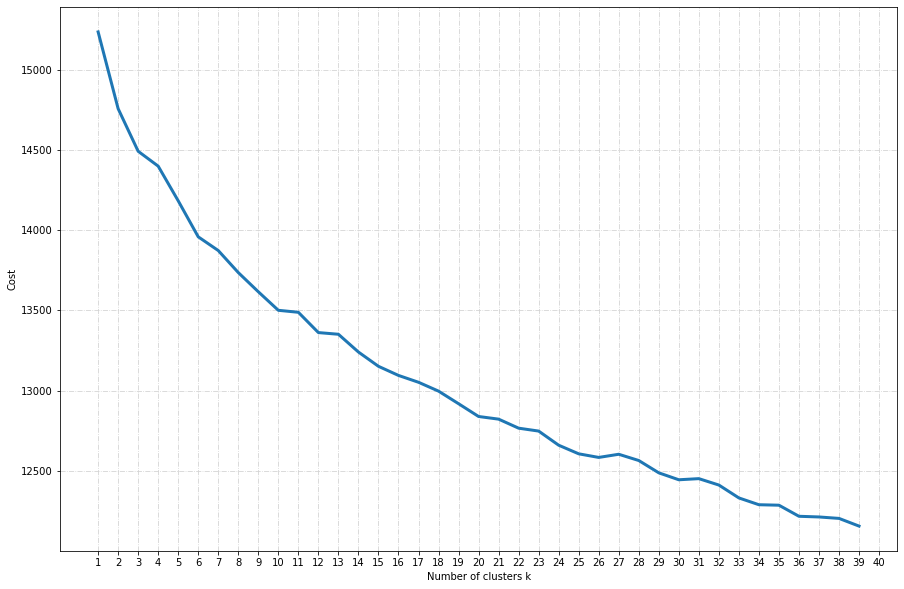

In [13]:
def elbow_method(data):
    total_variance = []
    for k in range(1, 40):
        print(k)
        kmeans = KMeans(n_clusters=k, max_iter = 100)# init='k-means++')
        kmeans.fit(data)
        total_variance.append(kmeans.inertia_)   #Sum of distances of samples to their closest cluster center
    
    #visualization of the curve
    fig = plt.figure(figsize=(15, 10))
    plt.xticks(range(1,41))
    plt.plot(range(1, 40), total_variance, linewidth = 3)
    plt.grid(color = 'lightgray', linestyle = '-.')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Cost')

fn.elbow_method(d)

COMMENT ON THE CHOICE OF K BASED ON THE GRAPH ABOVE

In [14]:
k = 20  #number of clusters

In [15]:
#we convert our initial dataframe d into an array for easier computation
vectors = np.array(d)

We first define some functions that will be then recalled inside the proper algorithm: this functions will be useful to determine the initial points of each cluster, compute the distance between each point and each cluster, in order to understand in which cluster that point has to be inserted, and, finally, compute the variance at each iteration of the algorthm in order to understand when the best cluster is achieved.

In [16]:
#fucntion that computes the euclidea distance between vectors 
def distance_between_products(x1,x2):
    return euclidean_distances(x1,x2)

In [17]:
'''function that assigns each point to a cluster. In input has:
- the centroids used in the specific iteration we are in
- the array 'vectors' that has as many rows as the unique products and as many columns as the significant words 
  that we have selected for the analysis
'''

def assign_points_to_clusters(centroids, vectors):
    clusters = []
    for i in range(vectors.shape[0]):
        distances = []
        for centroid in centroids:
            distance = distance_between_products([centroid], [vectors[i]])
            distances.append(distance)
            
        cluster_selected = [distances.index(min(distances)) + 1]    #to determine in which cluster to put that element
        clusters.append(cluster_selected)
    
    return clusters

In [18]:
'''function that calculates new centroids based on each cluster's mean'''

def define_new_centroids(clusters, vectors):
    new_centroids = []
    cluster_df = pd.concat([pd.DataFrame(vectors),pd.DataFrame(clusters, columns=['cluster'])], axis=1)
    
    for c in set(cluster_df['cluster']):
        
        current_cluster = cluster_df[cluster_df['cluster']==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    
    return new_centroids

In [19]:
'''function that calculates the variance within each cluster at each iteration'''

def variance(clusters, vectors):
    sum_squares = []
    cluster_df = pd.concat([pd.DataFrame(vectors),pd.DataFrame(clusters, columns=['cluster'])], axis=1)
    
    for c in set(cluster_df['cluster']):
        current_cluster = cluster_df[cluster_df['cluster']==c][cluster_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        mean_repmat = np.matlib.repmat(cluster_mean, current_cluster.shape[0],1)
        sum_squares.append(np.sum(np.sum((current_cluster - mean_repmat)**2)))
    
    return sum_squares

### Initialization

In [27]:
cluster_variance = []

initial_centroids = random.sample(range(0, len(d)), k)    # I choose k numbers random between 0 and the length of our dataset

#we use these numbers as indices to get the products associated at those centroids
centroids = []      
for i in initial_centroids:
    centroids.append(vectors[i])
    
clusters = fn.assign_points_to_clusters(centroids, vectors)
initial_clusters = clusters
print(0, round(np.mean(fn.variance(clusters, vectors))))

0 708


### Iterations

In [34]:
for i in range(10):
    centroids = define_new_centroids(clusters, vectors)
    clusters = assign_points_to_clusters(centroids, vectors)
    cluster_var = np.mean(variance(clusters, vectors))
    cluster_variance.append(cluster_var)
    
    if i == 0:
        print(i+1, round(cluster_var))
    
    else:
        if cluster_variance[i-1] - cluster_variance[i] > 1.0:
            print(i+1, round(cluster_var))
        else:
            break

1 669
2 669
3 668
4 667
5 664


KeyboardInterrupt: 

We can see that from the 6th iteration, the cluster variance pretty much stabilize, this means that the algorithm has found the best solution: the data points within each cluster stop changing.

We can visualize the change of viariance at each iteration from the graph below:

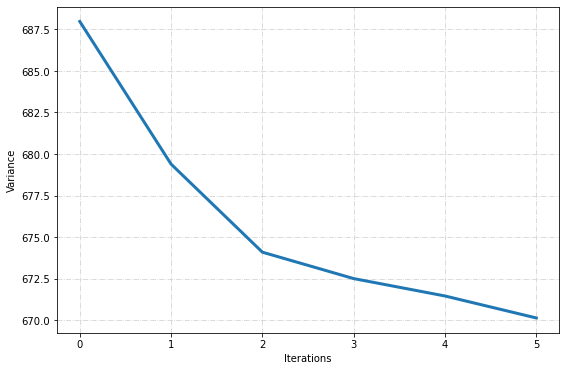

In [32]:
plt.figure(figsize=(9,6))
plt.plot(cluster_variance, linewidth = 3)
plt.grid(color = 'lightgray', linestyle = '-.')
plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.show()

We can also determine which were the initial products selected as centroids:

In [20]:
for i in initial_centroids:
    print(d.index[i])

B007XUK3RA
B004KUEQUG
B00012175O
B0001VWELG
B001SAYDTK
B004QQ82M2
B000HQMLKY
B000WG5GZG
B003Z9V2NW
B00032HPBW
B0030VJ8YU
B0029NILPW
B000QHF3CC


In [21]:
cluster_list = [cluster for list in clusters for cluster in list]

In [22]:
df = pd.DataFrame(list(reviews_per_product.items()),columns = ['ProductID','list_of_words']) 
df['cluster'] = cluster_list

We want to see now, how many products we have in each cluster:

In [40]:
df.groupby('cluster').ProductID.count()

cluster
1       264
2       702
3      2991
4        11
5       534
6      2089
7      5336
8       516
9      4347
10     1038
11     1862
12     4401
13    50167
Name: ProductID, dtype: int64

## Analysis of the clusters

Since we can retrieve the product Id of the prooducts inside the same cluster, we can now analyze the clusters a little bit deeper.

To do so we need to import the original dataset

In [ ]:
data = pd.read_csv('Reviews.csv')
data.drop('Id', axis = 1, inplace = True)
data.head()

### 1. Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a word cloud.

In [5]:
import wordcloud

In [6]:
def words_cloud(d,cluster_list):
    d['cluster']=cluster_list
    for cluster in range(13):
        print('Word cloud for cluster:', cluster)
        clus_df = d[d.cluster == 1]
        sum_scores = clus_df.sum(axis=0)
        words = dict(zip(d.columns[:-1],sum_scores[:-1]))
        Cloud = wordcloud.WordCloud(background_color="white", max_words=len(words)).generate_from_frequencies(words)
        plt.figure(figsize = (15, 10), facecolor = None) 
        plt.imshow(Cloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show()

In [7]:
words_cloud(d,cluster_list)

NameError: name 'd' is not defined

### 2. Provide the number of product in each cluster:
We have already answered this question above, when we grouped by the products based on the cluster they belonged. We are going to show again the final result here:

In [70]:
df.groupby('cluster').count()

cluster
1       264
2       702
3      2991
4        11
5       534
6      2089
7      5336
8       516
9      4347
10     1038
11     1862
12     4401
13    50167
Name: ProductID, dtype: int64

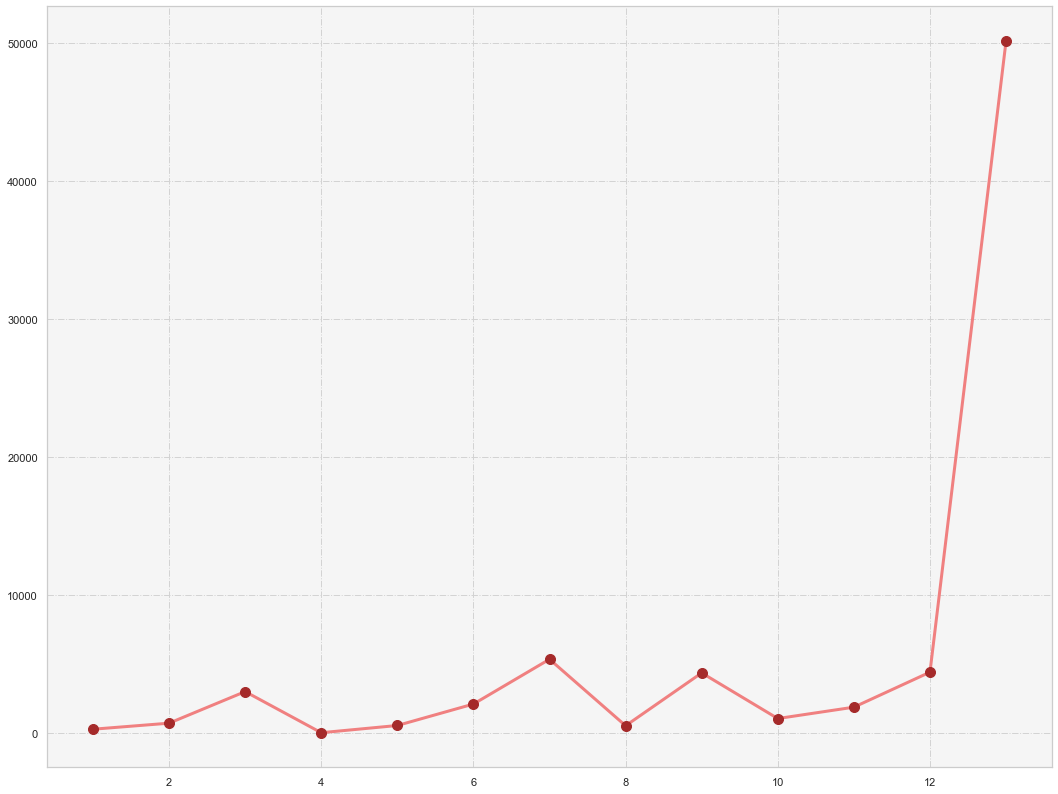

In [107]:
plt.figure(figsize = (18,14))
plt.plot(df.groupby('cluster').ProductID.count(), color = 'lightcoral',linewidth = 3, 
         marker = 'o', markersize = 10, mfc = 'brown', mec = 'brown')
plt.grid(color = 'lightgray', linestyle = '-.')
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.show()

As we can see, the algorithm that has the majoriry of products associated to, is **cluster number 13** which corrresponds to the following product IDs:

In [49]:
df[df.cluster == 13].ProductID

2        B000LQOCH0
3        B000UA0QIQ
4        B006K2ZZ7K
9        B001GVISJM
10       B00144C10S
            ...    
74250    B005ZC0RRO
74252    B006T7TKZO
74254    B001EO7N10
74255    B003S1WTCU
74257    B001LR2CU2
Name: ProductID, Length: 50167, dtype: object

### 3. Compute the reviews' score distribution in each cluster

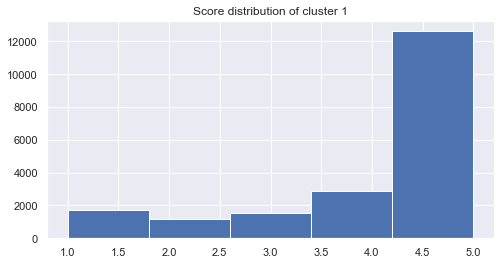

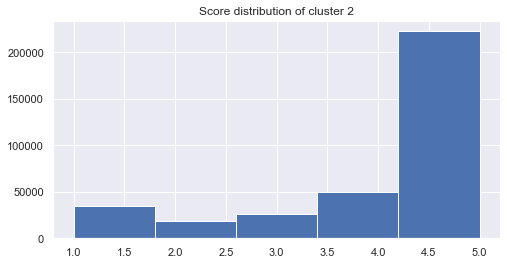

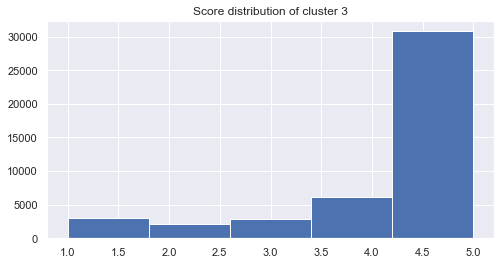

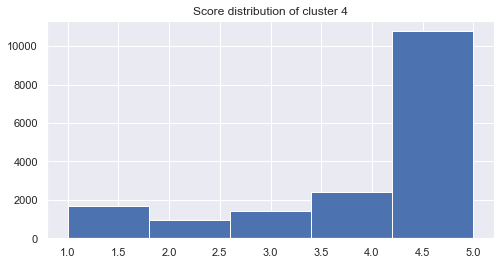

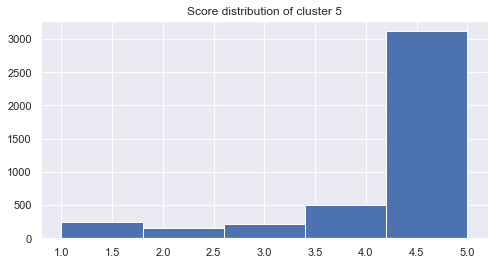

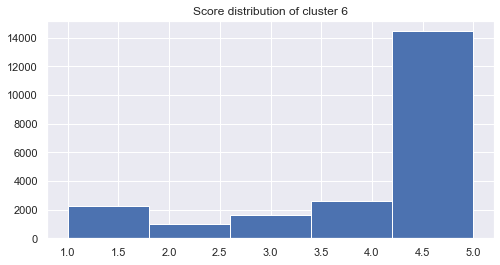

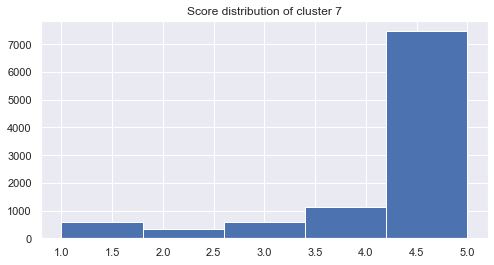

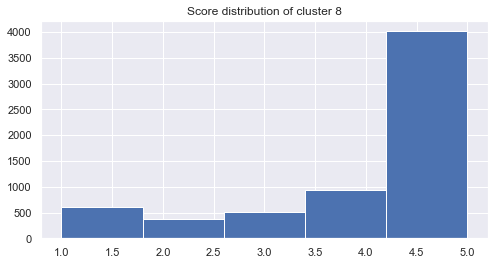

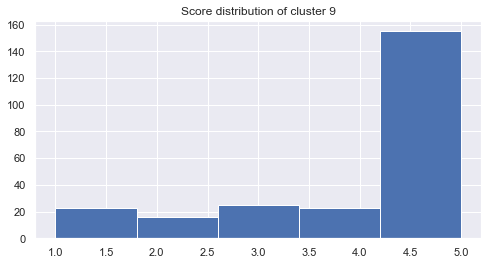

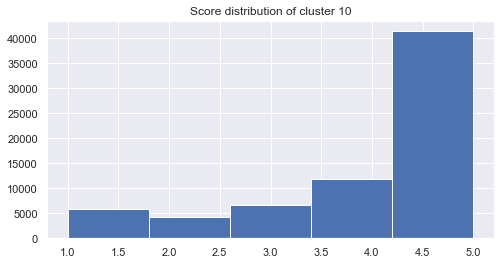

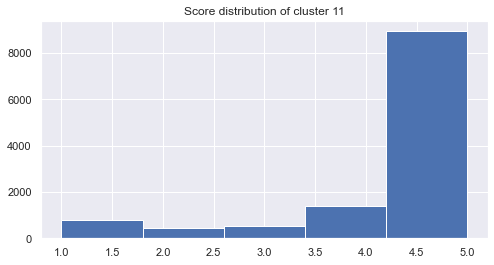

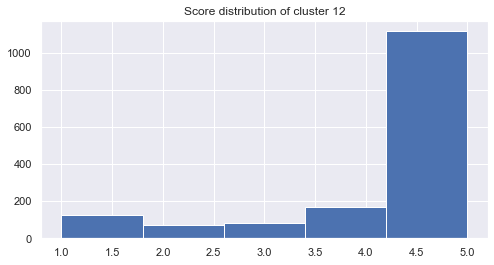

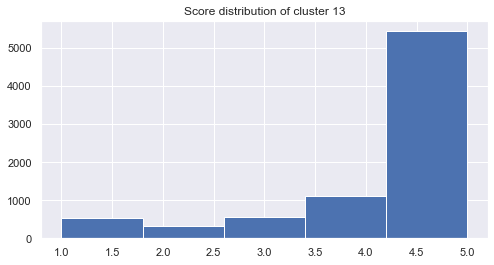

In [209]:
k = 13      #number of clusters

score_means = []

for i in range(k):
    
    l = list(df[df.cluster == i+1].ProductID)               #list of ProductId's inside cluster i+1
    
    d_l = data[data['ProductId'].isin(l)]                   #selecting only the rows of the original dataframe
                                                             #that conatin the reviews for those particular products
    score_means.append(d_l.Score.mean())
    
    #plot
    d_l.Score.hist(bins=5)
    plt.title(f'Score distribution of cluster {i+1}')
    plt.show()

In [217]:
for i in range(1,len(score_means)+1):
    print(f'mean of scores in cluster {i}: {round(score_means[i-1],3)}')

print(f'\nThe maximum value is: {round(max(score_means),3)} while the minimum is: {round(min(score_means),3)}')

mean of scores in cluster 1: 4.173
mean of scores in cluster 2: 4.156
mean of scores in cluster 3: 4.327
mean of scores in cluster 4: 4.136
mean of scores in cluster 5: 4.441
mean of scores in cluster 6: 4.185
mean of scores in cluster 7: 4.445
mean of scores in cluster 8: 4.144
mean of scores in cluster 9: 4.12
mean of scores in cluster 10: 4.131
mean of scores in cluster 11: 4.419
mean of scores in cluster 12: 4.336
mean of scores in cluster 13: 4.335

The maximum value is: 4.445 while the minimum is: 4.12


As we can see, although the number of products in each cluster in extremely different, the mean of the scores that the users give to the products in each cluster is basically the same, and is a very high value, always greater than 4

### 4. Get the number of unique users writing reviews in each cluster 

In [177]:
k = 13      #number of clusters

for i in range(k):
    
    l = list(df[df.cluster == i+1].ProductID)                   #list of ProductId's inside cluster i+1
    
    d_l = data[data['ProductId'].isin(l)]                       #selecting only the rows of the original dataframe
                                                                  #that conatin the reviews for those particular products
    
    number_of_users = len(d_l.UserId.unique())                  #number of unique users in those rows selected 
    
    print(f'number of unique users writing reviews in cluster {i+1}: {number_of_users}')

number of unique users writing reviews in cluster 1: 10878
number of unique users writing reviews in cluster 2: 175626
number of unique users writing reviews in cluster 3: 22916
number of unique users writing reviews in cluster 4: 12218
number of unique users writing reviews in cluster 5: 2474
number of unique users writing reviews in cluster 6: 8718
number of unique users writing reviews in cluster 7: 7823
number of unique users writing reviews in cluster 8: 3767
number of unique users writing reviews in cluster 9: 200
number of unique users writing reviews in cluster 10: 31982
number of unique users writing reviews in cluster 11: 7635
number of unique users writing reviews in cluster 12: 1409
number of unique users writing reviews in cluster 13: 6317
